In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.ensemble import VotingClassifier

Using TensorFlow backend.


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cancertreatment/stage2_test_text.csv
/kaggle/input/cancertreatment/test_text
/kaggle/input/cancertreatment/stage_2_private_solution.csv
/kaggle/input/cancertreatment/stage2_sample_submission.csv
/kaggle/input/cancertreatment/stage1_solution_filtered.csv
/kaggle/input/cancertreatment/test_variants
/kaggle/input/cancertreatment/stage2_test_variants.csv
/kaggle/input/cancer-diagnosis/training_text
/kaggle/input/cancer-diagnosis/training_variants


In [3]:
training_text = pd.read_csv("../input/cancer-diagnosis/training_text",sep="\|\|", header=None, skiprows=1, names=["ID","Text"])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [4]:
training_text.head(5)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
training_text.shape

(3321, 2)

In [6]:
training_variants = pd.read_csv("../input/cancer-diagnosis/training_variants")

In [7]:
training_variants.head(5)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [8]:
training_variants.shape

(3321, 4)

In [9]:
training_merge = training_variants.merge(training_text,left_on="ID",right_on="ID")

In [10]:
training_merge.head(5)
#Now we have the data

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [11]:
training_merge.shape

(3321, 5)

In [12]:
test_text = pd.read_csv("../input/cancertreatment/stage2_test_text.csv",sep="\|\|", header=None, skiprows=1, names=["ID","Text"])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [13]:
test_text.shape

(986, 2)

In [14]:
test_variants = pd.read_csv("../input/cancertreatment/stage2_test_variants.csv")

In [15]:
test_variants.shape

(986, 3)

In [16]:
test_merge = test_variants.merge(test_text,left_on="ID",right_on="ID")

In [17]:
# Let's understand the type of values present in each column of our dataframe 'train_merge' dataframe.
test_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986 entries, 0 to 985
Data columns (total 4 columns):
ID           986 non-null int64
Gene         986 non-null object
Variation    986 non-null object
Text         986 non-null object
dtypes: int64(1), object(3)
memory usage: 38.5+ KB


In [18]:
training_merge.describe(include='all')

,ID,Gene,Variation,Class,Text
count,3321.000000,3321,3321,3321.000000,3316
unique,NaN,264,2996,NaN,1920
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


In [19]:
training_merge.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
Text         5
dtype: int64

In [20]:
training_merge.columns

Index(['ID', 'Gene', 'Variation', 'Class', 'Text'], dtype='object')

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

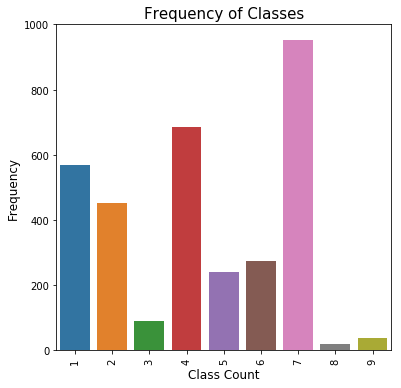

In [22]:
#Plot to see how classes are distributed
plt.figure(figsize=(6,6))
sns.countplot(x="Class", data=training_merge)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()

In [23]:
training_merge["Text_num_words"] = training_merge["Text"].apply(lambda x: len(str(x).split()) )
training_merge["Text_num_chars"] = training_merge["Text"].apply(lambda x: len(str(x)) )

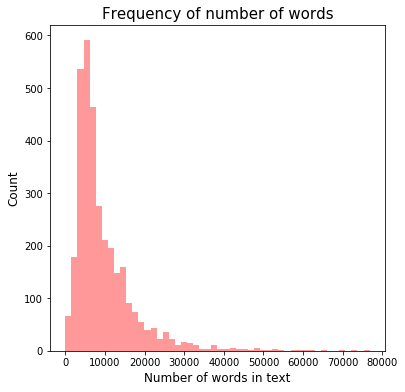

In [24]:
plt.figure(figsize=(6, 6))
sns.distplot(training_merge.Text_num_words.values, bins=50, kde=False, color='red')
plt.xlabel('Number of words in text', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Frequency of number of words", fontsize=15)
plt.show()

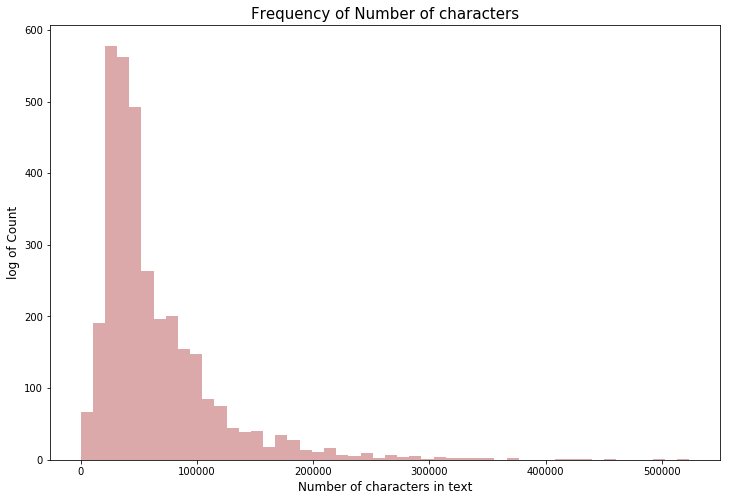

In [25]:
plt.figure(figsize=(12, 8))
sns.distplot(training_merge.Text_num_chars.values, bins=50, kde=False, color='brown')
plt.xlabel('Number of characters in text', fontsize=12)
plt.ylabel('log of Count', fontsize=12)
plt.title("Frequency of Number of characters", fontsize=15)
plt.show()

In [26]:
train_genes = training_merge.groupby('Gene')['Gene'].count()

for i in [2, 5, 10, 20, 50, 100, 300]:
    print('Genes that appear less than {} times: {}%'.format(i, round((train_genes < i).mean() * 100, 2)))

Genes that appear less than 2 times: 26.89%
Genes that appear less than 5 times: 53.03%
Genes that appear less than 10 times: 71.59%
Genes that appear less than 20 times: 82.95%
Genes that appear less than 50 times: 95.08%
Genes that appear less than 100 times: 98.11%
Genes that appear less than 300 times: 100.0%


In [27]:
training_merge['Variation'].describe()

count                     3321
unique                    2996
top       Truncating Mutations
freq                        93
Name: Variation, dtype: object

In [28]:
training_merge['Gene'].describe()

count      3321
unique      264
top       BRCA1
freq        264
Name: Gene, dtype: object

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


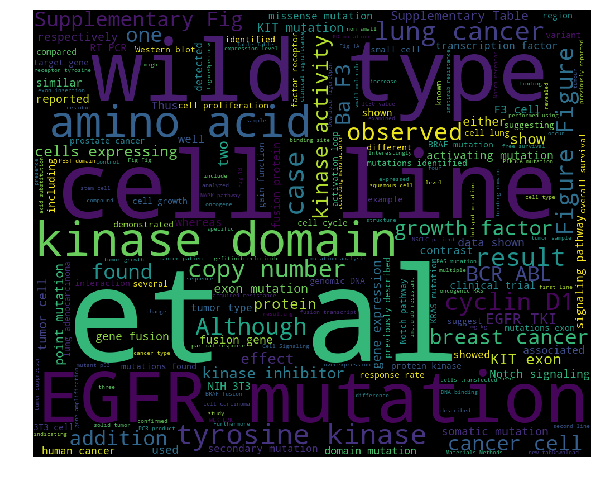

In [29]:
from wordcloud import WordCloud
cloud = WordCloud(width=1000, height=800).generate(" ".join(training_merge[training_merge.Class == 2]['Text']))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
ax = plt.axes()

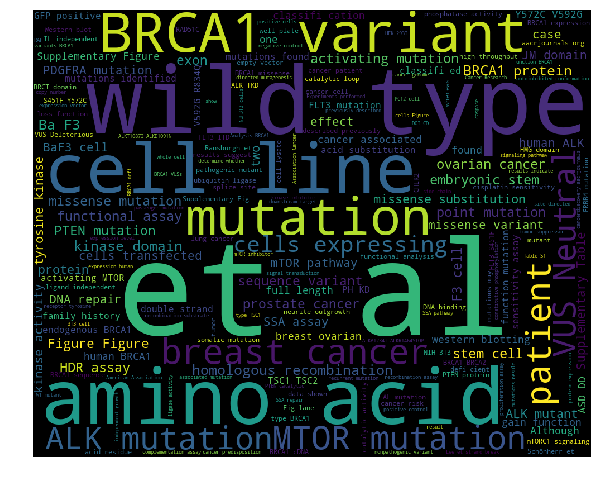

In [30]:
from wordcloud import WordCloud
cloud = WordCloud(width=1000, height=800).generate(" ".join(training_merge[training_merge.Class == 3]['Text']))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
ax = plt.axes()

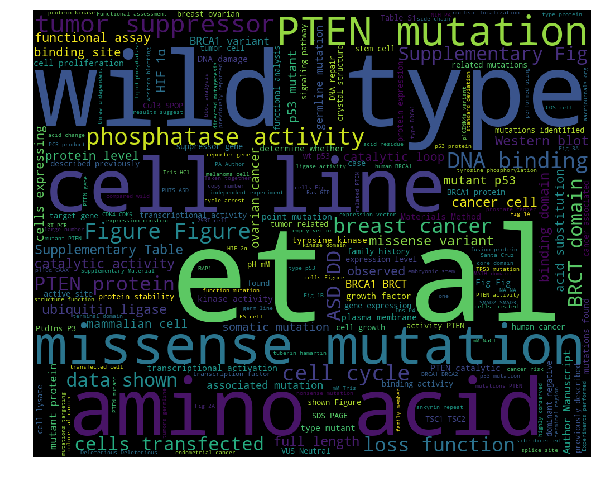

In [31]:
from wordcloud import WordCloud
cloud = WordCloud(width=1000, height=800).generate(" ".join(training_merge[training_merge.Class == 4]['Text']))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
ax = plt.axes()


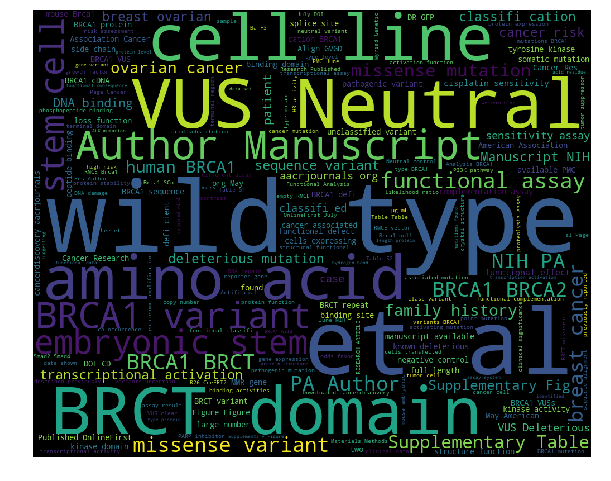

In [32]:
from wordcloud import WordCloud
cloud = WordCloud(width=1000, height=800).generate(" ".join(training_merge[training_merge.Class == 5]['Text']))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
ax = plt.axes()

Text(0.5, 1.0, 'Class 2 Text Word Cloud')

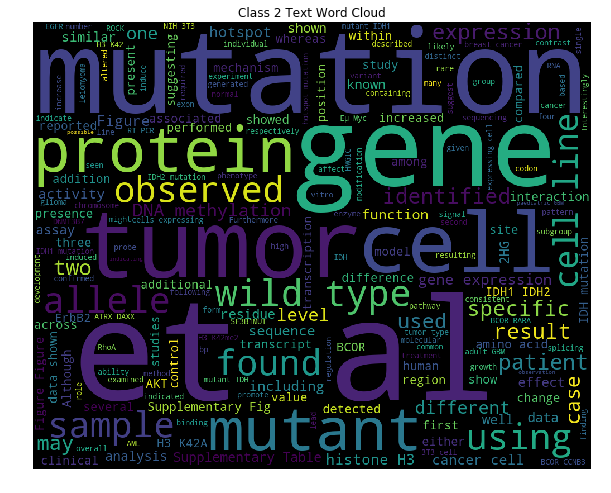

In [33]:
from wordcloud import WordCloud
cloud = WordCloud(width=1000, height=800).generate(" ".join(training_merge[training_merge.Class == 8]['Text']))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
ax = plt.axes()
ax.set_title('Class 2 Text Word Cloud')

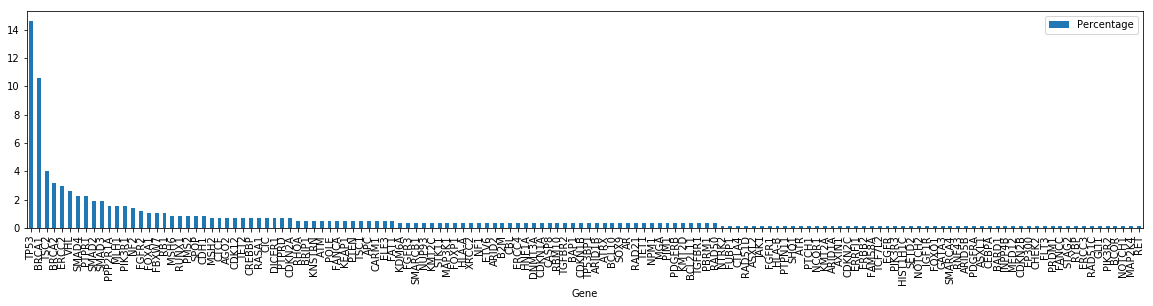

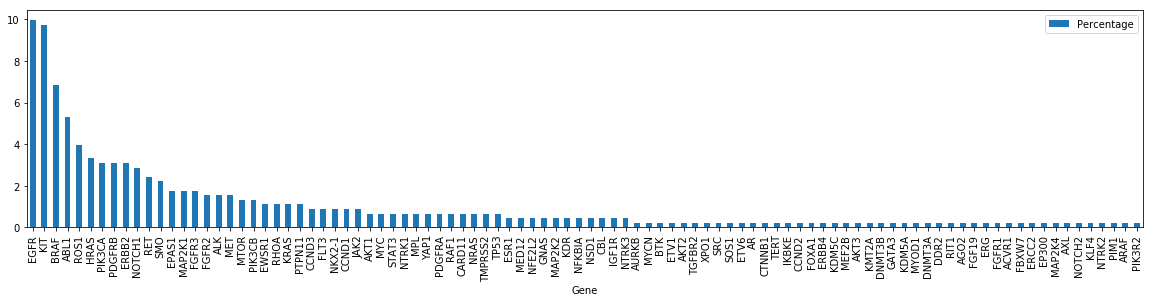

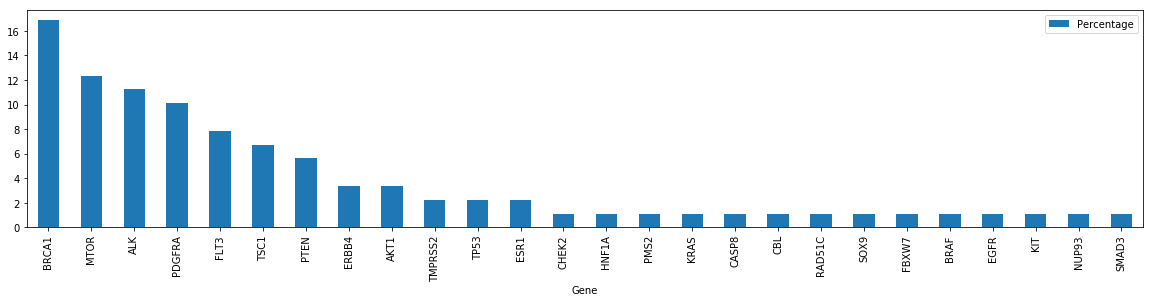

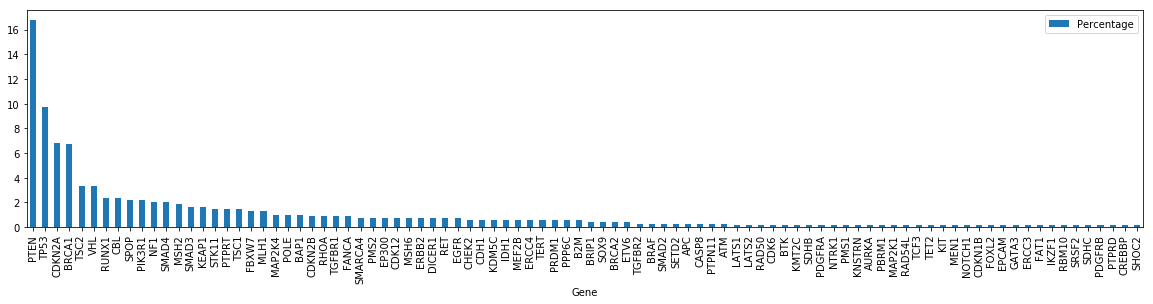

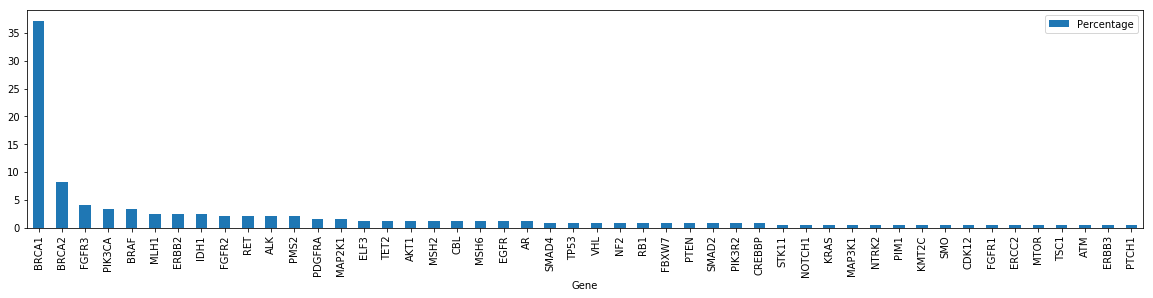

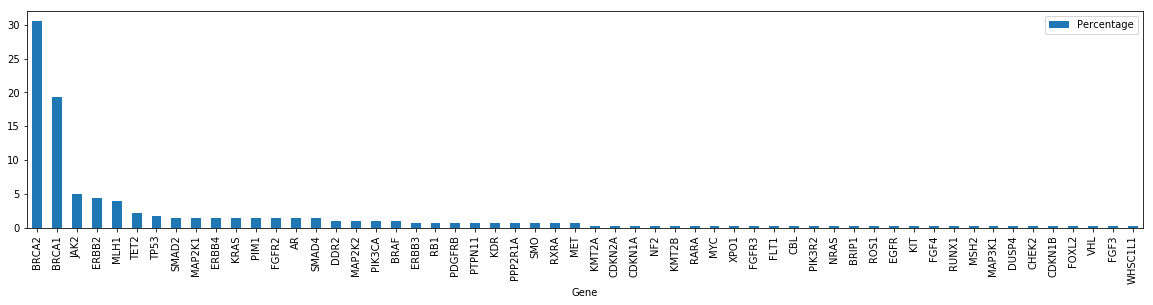

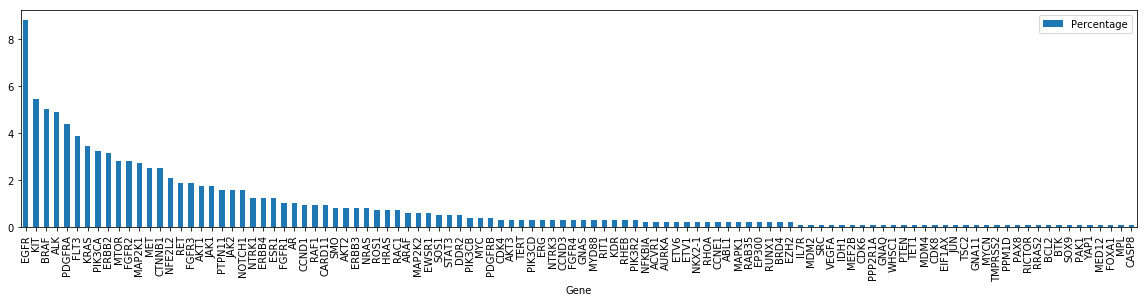

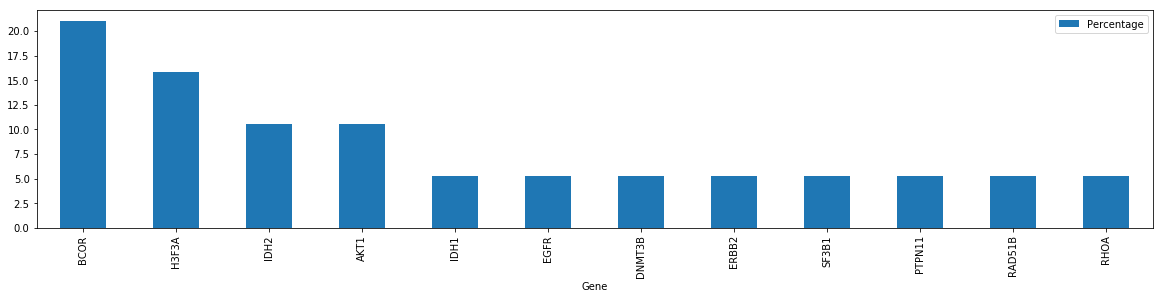

In [34]:
for i in range(1, 9):
    classs = training_merge.loc[training_merge['Class'] == i]

    cnt_genes = classs.Gene.value_counts().reset_index()
    cnt_genes.columns = ['Gene', 'Count']
    
    total = cnt_genes.Count.sum()
    
    cnt_genes['Percentage'] = (cnt_genes.Count/total)*100
    cnt_genes.plot(x='Gene', y='Percentage', kind='bar', figsize=(20,4))

In [35]:
cnt_genes.head()

,Gene,Count,Percentage
0,BCOR,4,21.052632
1,H3F3A,3,15.789474
2,IDH2,2,10.526316
3,AKT1,2,10.526316
4,IDH1,1,5.263158


In [36]:
cnt_genes.describe

<bound method NDFrame.describe of       Gene  Count  Percentage
0     BCOR      4   21.052632
1    H3F3A      3   15.789474
2     IDH2      2   10.526316
3     AKT1      2   10.526316
4     IDH1      1    5.263158
5     EGFR      1    5.263158
6   DNMT3B      1    5.263158
7    ERBB2      1    5.263158
8    SF3B1      1    5.263158
9   PTPN11      1    5.263158
10  RAD51B      1    5.263158
11    RHOA      1    5.263158>

In [37]:
s = training_merge.Gene.value_counts().reset_index()
s.columns=['Gene', 'Count']

In [38]:
cnt = s.Count.value_counts().reset_index()
cnt.columns = ['Occurence', 'Count']
total = cnt.Count.sum()

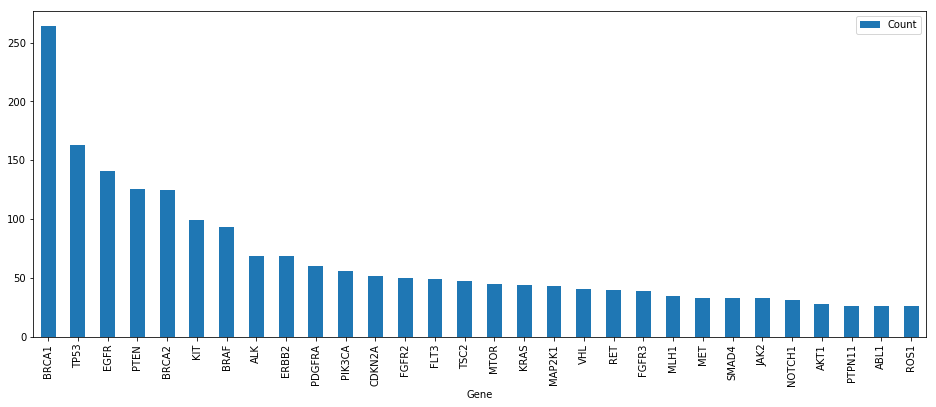

In [39]:
s.loc[s['Count'] > 25].plot(x='Gene', y='Count', kind='bar', figsize=(16, 6))